# DSCI 100 Group 12 Project Report

# Imports

In [1]:
### Run this cell before continuing.
import random

import altair as alt
import pandas as pd
import sklearn
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyClassifier

alt.data_transformers.disable_max_rows()
np.random.seed(1)

# Introduction

## Background

The sinking of the Titanic is one of the most known shipwrecks in history. The widely regarded "unsinkable" Titanic sank after striking an iceberg on April 15, 1912, while on her first voyage. Out of 2224 passengers and crew, 1502 perished because there were not enough lifeboats to go around.

Some people appeared to have higher survival rates than others, despite the fact that survival sometimes involved a certain amount of luck. Based on the provided passenger information, we’d love to explore the dataset and answer the question: what sorts of people were more likely to survive?

## Question

Given a passenger on the Titanic, predict whether they will survive the shipwreck.

## Dataset
The dataset we'll be using is from https://www.kaggle.com/competitions/titanic/data. They provide us with training and test data, but their test data does not provide the ground truth (target variable). Thus, we need to split the training data into train and test split.

The dataset contains a number of features such as the passengers sex, age, cabin number, and more. Our target variable will be the `Survival` feature which is 0 if the passenger did not survive, and 1 if they survived

More info about the dataset and it's features are described below

# Preliminary Exploratory Data Analysis

## Reading the data
> Note: there doesn't seem to be a URL for the dataset. Therefore, we've downloaded the data from Kaggle using the link https://www.kaggle.com/competitions/titanic/data and have moved the csv files into a data directory.

We decided to split our data into 70% training and 30% test making sure to set `random_state=123`

In [2]:
df = pd.read_csv('data/train.csv')
training_data, test_data = train_test_split(df, test_size=0.3, random_state=123, stratify=df['Survived'])
print(f'Original data set size = {df.shape[0]}, train size = {training_data.shape[0]}, test size = {test_data.shape[0]}')
training_data

Original data set size = 891, train size = 623, test size = 268


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
468,469,0,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
574,575,0,3,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.0500,NaN,S
776,777,0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.7500,F38,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,NaN,S
669,670,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


## Description of Features
These were taken from https://www.kaggle.com/competitions/titanic/data

| Variable | Definition                                                                                          |
|----------|-----------------------------------------------------------------------------------------------------|
| survival | 1 = survived, 0 = did not survive                                                                   |
| pclass   | Ticket class - a proxy for socio-economic status 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower) |
| sex      | Sex (male or female)                                                                                |
| age      | Age in years - is fractional if less than 1 - if it's estimated, it's in the form xx.5              |
| sibsp    | # of siblings / spouses aboard the Titanic                                                          |
| parch    | # of parents / children aboard the Titanic                                                          |
| ticket   | Ticket number                                                                                       |
| fare     | Passenger fare                                                                                      |
| cabin    | Cabin number                                                                                        |
| embarked | Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton                                  |

## Cleaning and wrangling data into a tidy format

The data is already clean and wrangled. Namely
- Each row is a single observation (a single passenger)
- Each column is a single variable
- Each cell contains a single value

Furthermore, the column names are easy to read and use already (no spaces in them) and missing values are represented with `NaN`.

## Summarizing the Data

Here we use `DataFrame::info()` and `DataFrame::describe()` to discover

1. The number of observations for each column and whether we're missing any observations
2. What `Dtype` each column/feature has
3. The mean, std, quartiles, min and max of numerical features

In [3]:
display(training_data.info())
display(training_data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 199 to 768
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  623 non-null    int64  
 1   Survived     623 non-null    int64  
 2   Pclass       623 non-null    int64  
 3   Name         623 non-null    object 
 4   Sex          623 non-null    object 
 5   Age          501 non-null    float64
 6   SibSp        623 non-null    int64  
 7   Parch        623 non-null    int64  
 8   Ticket       623 non-null    object 
 9   Fare         623 non-null    float64
 10  Cabin        130 non-null    object 
 11  Embarked     622 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 63.3+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,623.000000,623.000000,623.000000,623,623,501.000000,623.000000,623.000000,623,623.000000,130,622
unique,NaN,NaN,NaN,623,2,NaN,NaN,NaN,511,NaN,106,3
top,NaN,NaN,NaN,"Yrois, Miss. Henriette (""Mrs Harbeck"")",male,NaN,NaN,NaN,CA. 2343,NaN,F2,S
freq,NaN,NaN,NaN,1,402,NaN,NaN,NaN,6,NaN,3,444
mean,447.568218,0.383628,2.337079,NaN,NaN,28.941457,0.529695,0.369181,NaN,31.634884,NaN,NaN
std,260.622773,0.486660,0.820961,NaN,NaN,14.147209,1.140599,0.792943,NaN,52.533832,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,438.000000,0.000000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,13.791700,NaN,NaN
75%,687.000000,1.000000,3.000000,NaN,NaN,37.000000,1.000000,0.000000,NaN,30.285400,NaN,NaN


We can see that the features with missing values include `Age`, `Cabin` and `Embarked`. `Cabin` has the most missing number of values, so it may not be useful for our model to learn this feature.

Furthermore, `Name` in our training set is a unique feature for each passenger, so it may not be that useful. We'll expand further on this in the [Methods](#methods) section.

Next, we find the number of observations in each class

In [4]:
display(training_data['Survived'].value_counts())
display(training_data['Survived'].value_counts(normalize=True))

0    384
1    239
Name: Survived, dtype: int64

0    0.616372
1    0.383628
Name: Survived, dtype: float64

We can see there are 379 passengers in the training set that did not survive (roughly 61%) and 244 passengers that survived (roughly 39%).

## Visualizing the Data


For visualizing the data, we'll focus on the following subset of features for now. We explain in the [Features/Variables/Columns](#featuresvariablescolumns) section which predictor variables we'll use and why.

In [5]:
training_data_selected = training_data[training_data["Age"].notnull()].loc[:,["Survived","Sex","Pclass","Age","SibSp","Parch","Fare"]]
training_data_selected

,Survived,Sex,Pclass,Age,SibSp,Parch,Fare
199,0,female,2,24.0,0,0,13.0000
574,0,male,3,16.0,0,0,8.0500
148,0,male,2,36.5,0,2,26.0000
227,0,male,3,20.5,0,0,7.2500
408,0,male,3,21.0,0,0,7.7750
...,...,...,...,...,...,...,...
823,1,female,3,27.0,0,1,12.4750
209,1,male,1,40.0,0,0,31.0000
737,1,male,1,35.0,0,0,512.3292
360,0,male,3,40.0,1,4,27.9000


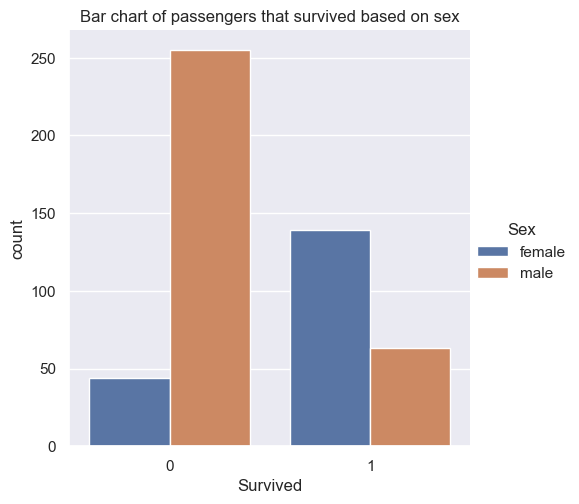

In [6]:
import seaborn as sns
sns.set()
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Sex').set(title='Bar chart of passengers that survived based on sex')

**_Fig_.1 Comparing survival of passengers based on sex**

From this we can see that more females survived than males since there were more than 125 that survived compared to only about 70 males survived).
Furthermore, more than 200 males did not survive compared to just under 50 females.

After some further research, it seems that the rule for loading the lifeboats were women and children first. If this was the case, we'd expect the percentage of those with younger ages to have survived more than the percentage of adults/older people if children were prioritized. Let's see if this is the case

In [7]:
(
    alt.Chart(training_data_selected)
    .mark_bar()
    .encode(
        x= alt.X("Age", bin=alt.Bin(maxbins=30)),
        y=alt.Y("count()", stack=False),
        color = 'Survived:N'
    )
    .properties(
        width=600,
        height=400
    )
    .facet(
        facet=alt.Facet('Sex', header=alt.Header(labelFontSize=14)),
        title='Histogram of Passenger Age Colored by Survival and Split by Sex'
    )
    .configure_axis(titleFontSize=14)
)


c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

**_Fig_.2 Distribution of passenger survival across age and split by sex**

Here we show the distribution of the `Age` variable, using color to separate those who survived and those who didn't. We facet the plot to separate further by sex.

We can see that those with ages less than or equal to 10, regardless of sex, had a much higher survival rate. Furthermore, females seemed to have better chances of surviving than males. This does in fact provide better evidence that there was a rule for loading females and children first in lifeboats.

Next, let's see if the ticket class (a proxy for social economic status) plays a role in the survival rate.

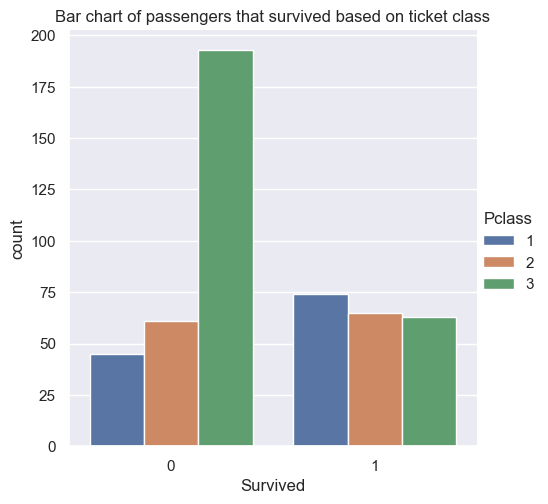

In [8]:
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Pclass').set(title='Bar chart of passengers that survived based on ticket class')

**_Fig_.3 Comparison of number of survived passengers based on ticket class (a proxy for socio-economic status 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower))**

From this we can see that most people who failed to survive are from the 3rd class, whereas those that survived the most are from the 1st class.

Next, let's compare the survival rate with the price of the cabin. We create a histogram with the x-axis as the passenger fairs grouped into buckets and the y-axis showing the percentage of passengers in the buckets that survived.

In [9]:
(
    alt.Chart(training_data_selected, title="Normalized Histogram of Fare Price to Percentage of Survivors")
    .mark_bar()
    .encode(
        x= alt.X("Fare", bin=alt.Bin(maxbins=15), title="Fare (£)"),
        y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%'), title="Percentage of Records"),
        color = 'Survived:N'
    )
)


c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

**_Fig_.4 Distribution of passenger survival based on fare price of ticket**

Interestingly, we can observe that those who paid very cheap fares did not survive as much compared to those who paid more expensive fares greater than or equal to £50. We can see an outlier with a 100% survival rate for those that paid a fare of more than £500.

# Methods and Results

## Procedure for Data Analysis

To conduct our data analysis, first, we'll define the necessary column transformer and pipeline to preprocess our data. We'll use `KNN` to perform the classification and use cross-validation to tune the hyperparameter `n_neighbors` for `KNN` by choosing the value with the highest validation score. We'll use grid search to explore the possible values of `n_neighbors`. We need to do hyperparameter optimization because it's difficult to tell blindly at first what the best hyperparameter value of `n_neighbors` is, and we need to use cross-validation to get a robust approximation of generalization error.

After we obtain our best model, we'll evaluate it against the test set to get the test score. We'll be using the accuracy metric as it's generally a good baseline metric to use first when evaluating models. Because we have some class imbalance, our dummy classifier (baseline) would achieve an accuracy of approximately 61% by always predicting a passenger will not survive. Since there isn't an extreme amount of class imbalance, accuracy won't be a misleading metric.

The reason for choosing `KNN` is because it's a simple classification model that requires few assumptions of what the data should look like and it's fast in terms of training (fit time).

## Features/Variables/Columns

This list may change when we conduct our analysis, but so far these are the features/predictor variables we plan on using and why:

For the first three bullet points (numerical, categorical and binary features), we believe all these features could be useful for our model to decipher and learn interesting patterns about the Titanic passengers, which would be helpful in predicting whether new passengers will survive or not.

- Numerical Features
  - `Age`, `SibSp`, `Parch`, `Fare`
  - Transformation: Scaling, Imputation (`Age` has some missing values)
- Categorical Features
  - `Embarked`
  - Transformation: OneHotEncoding, Imputation (`Embarked` has some missing values)
- Binary Features
  - `Sex`
  - Transformation: OneHotEncoding (binary)
- Ordinal Features
  - `Pclass` (it has a natural ordering)
  - Transformation: none
- Dropped Features
  - `PassengerId` &#8594; because it's unique and just used as the index
  - `Cabin` &#8594; there are too many missing values
  - `Ticket` &#8594; These are all unique for each passenger and our model may not learn any useful patterns based on this
  - `Name` &#8594; again, since this feature is unique, it doesn't provide useful patterns.
- Possible feature engineering if time
  - We could potentially use the `Cabin` feature by extracting the letter prefix
  - For example, if the passenger stays in `Cabin=D26`, we could create a new feature `CabinLevel=D`. This may be useful for our model to learn which level of the boat they belonged in, and we could impute the missing values with some constant.
    - ![img/titanic_diagram.png](https://user-images.githubusercontent.com/49849754/224509673-c01b997a-46db-4e38-b04b-81a27e9c64bd.png)
  - Further details can be found here: https://www.encyclopedia-titanica.org/cabins.html
  - Another feature we could extract is the last name of each passenger. If a model learns that those within the same family survived, then given a passenger with the same last name belonging to the family, it can predict that the passenger survived. However, this may be a complex feature to extract and will require further investigation.

## Creating Training and Test Data

Now let's further split our training and test data into `X_train`, `y_train`, `X_test`, and `y_test`.

In [10]:
X_train = training_data.drop(columns=["Survived"])
X_test = test_data.drop(columns=["Survived"])

y_train = training_data["Survived"]
y_test = test_data["Survived"]

X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199,200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
468,469,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
198,199,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
574,575,3,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.0500,NaN,S
776,777,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.7500,F38,Q
...,...,...,...,...,...,...,...,...,...,...,...
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
360,361,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,NaN,S
669,670,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
245,246,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


## Creating a baseline

Next, let's create a baseline using `sklearn DummyClassifier` so we have some base score to compare against.

Note: I'll be using the helper function `mean_std_cross_val_scores` inspired from CPSC 330 to calculate the scores

In [11]:
# Credits to CPSC 330
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [12]:
baseline_model = DummyClassifier(strategy='prior')

result = {}
result['baseline'] = mean_std_cross_val_scores(
    baseline_model, X_train, y_train, return_train_score=True, scoring='accuracy', cv=10
)

pd.DataFrame(result).T

,fit_time,score_time,test_score,train_score
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)


Here we can see that the dummy classifier achieves an accuracy of 0.616 since it's always predicting that a passenger did not survive (class=0) since that's the most common label. This agrees with the proportion of passengers that did not survive in the training data as was seen in our EDA.

## Model Tuning & Hyperparameter Evaluation

In this section, we'll be trying out several models in the following order

1. KNN with Two Numerical Features
2. KNN with `SelectKBest`
3. Multivariate KNN with All Features
4. Various other models (`DecisionTreeClassifier`, ensemble methods, etc.)

Before we begin, we'll create a helper method to tune our KNN model parameters and perform grid search since we'll be doing this a couple of times and we want to avoid repetitive code.

The code below does the following:
- defines a parameter grid of different `n_neighbor` values to try
- performs grid search
- prints out the best validation score and hyperparameters
- performs cross validation on the best model to add it to our `result` object
- returns the grid search object

In [13]:
def tune_knn(pipe, modelName):
    # define parameter grid and perform grid search
    parameter_grid = {
        "kneighborsclassifier__n_neighbors": range(1, 100, 5),
    }

    knn_grid = GridSearchCV(
        estimator=pipe,
        param_grid=parameter_grid,
        cv=10,
        scoring='accuracy',
        return_train_score=True,
    )

    display(knn_grid.fit(X_train, y_train))

    print(f'Best {knn_grid.scoring} score: {knn_grid.best_score_}')
    print(f'Best hyper-parameters: {knn_grid.best_params_}')
    cv_results = pd.DataFrame(knn_grid.cv_results_)[
        [
            "rank_test_score",
            "mean_test_score",
            "std_test_score",
            "mean_train_score",
            "std_train_score",
            "param_kneighborsclassifier__n_neighbors"
        ]
    ].set_index("rank_test_score").sort_index().T
    display(cv_results)

    result[modelName] = mean_std_cross_val_scores(
        knn_grid.best_estimator_, X_train, y_train, return_train_score=True, scoring='accuracy', cv=10
    )

    display(pd.DataFrame(result).T)

    return knn_grid, cv_results


### 1. KNN with Two Numerical Features

First, let's try selecting two numerical features like `Age` and `Fare` so that we can visualize the decision boundary and get a sense of how our simple model compares to the baseline. These were the two features we explored in our EDA and may be worth investigating as a first try.

We'll follow the standard approach we learned in class where we create a preprocessor and a model with `KNeighborsClassifier`. Then we'll merge those into a pipeline and perform grid search to find the optimal value of `n_neighbors`. Once we've found the best value of our hyperparameter, we'll then evaluate its cross validation accuracy and report the results compared to the baseline.

Since our dataset contains missing values, we'll use `SimpleImputer` to impute missing values for the feature `Age`.

In [14]:
# create KNN model
knn = KNeighborsClassifier()

# create centering/scaling preprocessor with imputation
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ["Age", "Fare"]),
)

# create pipeline
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

knn_grid, _ = tune_knn(knn_pipe, 'knn (age & fare)')


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 100, 5)},
             return_train_score=True, scoring='accuracy')

Best accuracy score: 0.6757552483358935
Best hyper-parameters: {'kneighborsclassifier__n_neighbors': 6}


rank_test_score,1,2,3,4,4,6,6,6,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.675755,0.675678,0.675653,0.674066,0.674066,0.672478,0.672478,0.672478,0.670968,0.669252,0.669227,0.66275,0.661214,0.6532,0.653123,0.65151,0.65,0.648438,0.648285,0.624424
std_test_score,0.045235,0.047503,0.037314,0.032953,0.038757,0.033719,0.04189,0.038745,0.04318,0.038786,0.040251,0.054216,0.049944,0.044373,0.044996,0.046106,0.044717,0.035695,0.044138,0.045375
mean_train_score,0.734798,0.68022,0.688604,0.685926,0.684859,0.681113,0.680576,0.679151,0.722845,0.688069,0.676297,0.669522,0.696093,0.661669,0.657214,0.658641,0.659352,0.696451,0.658283,0.952022
std_train_score,0.009309,0.004989,0.005335,0.005066,0.00392,0.004923,0.00435,0.00609,0.010352,0.003192,0.008896,0.010028,0.005493,0.011112,0.008287,0.008947,0.006222,0.004124,0.007106,0.004279
param_kneighborsclassifier__n_neighbors,6,61,36,31,41,46,51,56,11,26,66,71,21,76,96,91,81,16,86,1


,fit_time,score_time,test_score,train_score
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)
knn (age & fare),0.012 (+/- 0.003),0.012 (+/- 0.004),0.676 (+/- 0.048),0.735 (+/- 0.010)


Based on our grid search, it seems the best hyperparameter of `n_neighbors=6` was found which achieved a a training score of about 0.735 and validation score of about 0.676. This is a slight improvement over the baseline, but not a great improvement.

Next, we'll show the scatter plot with a decision boundary similar to [Fig 5.15](https://python.datasciencebook.ca/classification1.html#:~:text=unscaled_plot%20%2B%20prediction_plot-,Fig,-.%205.15%20Scatter%20plot) from the textbook. This allows us to better understand what boundary the model is making.

In [15]:
# Credits to this code comes from: https://python.datasciencebook.ca/classification1.html#:~:text=unscaled_plot%20%2B%20prediction_plot-,Fig,-.%205.15%20Scatter%20plot

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid = np.linspace(
    training_data["Fare"].min(), training_data["Fare"].max(), 50
)
smo_grid = np.linspace(
    training_data["Age"].min(), training_data["Age"].max(), 50
)
asgrid = np.array(np.meshgrid(are_grid, smo_grid)).reshape(2, -1).T
asgrid = pd.DataFrame(asgrid, columns=["Fare", "Age"])

# use the fit workflow to make predictions at the grid points
knnPredGrid = knn_grid.predict(asgrid)

# bind the predictions as a new column with the grid points
prediction_table = asgrid.copy()
prediction_table["Survived"] = knnPredGrid

# plot:
# 1. the colored scatter of the original data
unscaled_plot = (
    alt.Chart(
        training_data,
    )
    .mark_point(opacity=0.6, filled=True, size=40)
    .encode(
        x=alt.X(
            "Fare",
            title="Fare (£)",
            scale=alt.Scale(
                domain=(training_data["Fare"].min(), training_data["Fare"].max()),
            ),
        ),
        y=alt.Y(
            "Age",
            title="Age",
            scale=alt.Scale(
                domain=(
                    training_data["Age"].min(),
                    training_data["Age"].max(),
                )
            ),
        ),
        color=alt.Color("Survived:N", title="Survived"),
    )
)

# 2. the faded colored scatter for the grid points
prediction_plot = (
    alt.Chart(prediction_table)
    .mark_point(opacity=0.15, filled=True, size=300)
    .encode(
        x=alt.X("Fare", title="Fare (£)"),
        y=alt.Y("Age"),
        color=alt.Color("Survived:N"),
    )
)
(unscaled_plot + prediction_plot).properties(
    width=800,
    height=300,
    title='Decision boundary of KNN based on Age and Fare'
)

c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

**_Fig_.5 Scatter plot of Age versus Fare where background color indicates the decision boundaries of the classifier**

Based on the figure above, we can see that there are some outlier passengers who paid very high fares that survived. We can also see towards the bottom corner that children who paid low fares mostly survived. However, those with cheap fares and higher age mostly did not survive (the large blue region at the very left).

This also explains why our model isn't performing that well against the validation set because we can see it's making a lot of mistakes for the large concentration of passengers with low fares.

### 2. KNN with `SelectKBest`

Next, we can try a more informed process of using [SelectKBest](https://www.datatechnotes.com/2021/02/seleckbest-feature-selection-example-in-python.html) to extract the best features that influence the survival rate.

#### Identifying the most influential features

In order to run `SelectKBest`, we need to first convert categorical and binary features (Embarked,Sex) to numerical features.

In [16]:
# Select the relevant features first
training_data1 = training_data[["Pclass","Sex","Age","Embarked","SibSp","Parch","Fare","Survived"]].dropna()
X_feature = training_data1[["Pclass","Sex","Age","Embarked","SibSp","Parch","Fare"]]
y_feature = training_data1["Survived"]
X_feature

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
199,2,female,24.0,S,0,0,13.0000
574,3,male,16.0,S,0,0,8.0500
148,2,male,36.5,S,0,2,26.0000
227,3,male,20.5,S,0,0,7.2500
408,3,male,21.0,S,0,0,7.7750
...,...,...,...,...,...,...,...
823,3,female,27.0,S,0,1,12.4750
209,1,male,40.0,C,0,0,31.0000
737,1,male,35.0,C,0,0,512.3292
360,3,male,40.0,S,1,4,27.9000


In [17]:
X_feature["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
# Embarked
X_feature.loc[X_train["Embarked"] == "S", "Embarked"] = 1
X_feature.loc[X_train["Embarked"] == "C", "Embarked"] = 2
X_feature.loc[X_train["Embarked"] == "Q", "Embarked"] = 3

# Sex
X_feature.loc[X_train["Sex"]=="male", "Sex"]   = 1
X_feature.loc[X_train["Sex"]=="female", "Sex"] =2

X_feature

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
199,2,2,24.0,1,0,0,13.0000
574,3,1,16.0,1,0,0,8.0500
148,2,1,36.5,1,0,2,26.0000
227,3,1,20.5,1,0,0,7.2500
408,3,1,21.0,1,0,0,7.7750
...,...,...,...,...,...,...,...
823,3,2,27.0,1,0,1,12.4750
209,1,1,40.0,2,0,0,31.0000
737,1,1,35.0,2,0,0,512.3292
360,3,1,40.0,1,1,4,27.9000


Then, we can use `SelectKBest` to find out the `p_value` and `scores` of each feature, and to get an optimal fit between bias and variance.

In [19]:
# Perform SelectKBest to get scores of all features
feature = SelectKBest(f_classif,k="all")
feature_fit = feature.fit(X_feature,y_feature)
score = feature_fit.scores_.round(3)
p_values = -np.log10(feature_fit.pvalues_).round(3)

In [20]:
feature_list = list(X_feature.columns.values)
selected_features = feature.get_support([feature_fit])
selected_features

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [21]:
# create a temp list to select the features
temp_list=[]
for i in selected_features:
    temp_list.append({'Feature':feature_list[i], 'P_value':p_values[i],'Score':score[i]})

# modify the selected feature list
feature_select = pd.DataFrame(temp_list)
feature_select = feature_select.sort_values(by='Score', ascending=False)
feature_select = feature_select.set_index('Feature')
feature_select    

,P_value,Score
Feature,,
Sex,40.091,215.609
Pclass,13.106,59.159
Fare,6.260,25.752
Embarked,1.886,6.212
Parch,1.582,4.975
Age,1.040,2.863
SibSp,0.003,0.000


Now we can see the `scores` and `p-values` of the features. We can make a visualization of it

<AxesSubplot: title={'center': 'P-Values and Scores of Various Features'}, xlabel='Feature', ylabel='P-Values and Scores'>

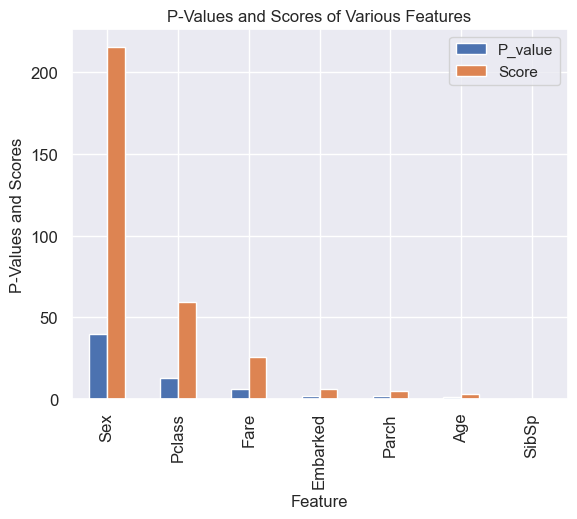

In [22]:
ax = feature_select[['P_value','Score']].plot(kind='bar', title ="P-Values and Scores of Various Features",  legend=True, fontsize=12)
ax.set_xlabel("Feature", fontsize=12)
ax.set_ylabel("P-Values and Scores", fontsize=12)
ax                                   

**_Fig_.6 Comparisons of P-values and Scores between variables**

From the graph showing above, we can see that the two features `Sex` and `PClass` have the highest `p-value` and `score`, thus they have the most influence on whether the passenger survived. Therefore, we'll use `Sex` and `Age` as our main features for the KNN model.

#### Tuning hyperparameters and Cross-Validation

Now that we have our best features, we can tune our hyperparameters and evaluate the cross-validation accuracy.


In [23]:
# create centering/scaling preprocessor with imputation
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Sex']),
    ('passthrough', ['Pclass'])
)

# create pipeline
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

knn_grid, cv_results = tune_knn(knn_pipe, 'knn SelectKBest')

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Sex']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Pclass'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 100, 5)},
             return_train_score=True, scoring='accuracy')

Best accuracy score: 0.7992063492063493
Best hyper-parameters: {'kneighborsclassifier__n_neighbors': 11}


rank_test_score,1,2,2,2,2,2,2,2,2,2,11,12,13,13,13,13,13,18,19,20
mean_test_score,0.799206,0.797542,0.797542,0.797542,0.797542,0.797542,0.797542,0.797542,0.797542,0.797542,0.791142,0.786431,0.784844,0.784844,0.784844,0.784844,0.784844,0.776856,0.73533,0.707552
std_test_score,0.057511,0.054484,0.054484,0.054484,0.054484,0.054484,0.054484,0.054484,0.054484,0.054484,0.061449,0.058827,0.041191,0.041191,0.041191,0.041191,0.041191,0.03648,0.05543,0.107786
mean_train_score,0.79044,0.79775,0.79775,0.79775,0.79775,0.79775,0.79775,0.79775,0.79775,0.79775,0.794183,0.794,0.79775,0.79775,0.79775,0.79775,0.79775,0.777425,0.776874,0.718944
std_train_score,0.00729,0.006066,0.006066,0.006066,0.006066,0.006066,0.006066,0.006066,0.006066,0.006066,0.008319,0.013663,0.006066,0.006066,0.006066,0.006066,0.006066,0.024763,0.021683,0.082635
param_kneighborsclassifier__n_neighbors,11,46,61,56,51,36,41,26,21,31,16,91,81,66,71,76,86,6,96,1


,fit_time,score_time,test_score,train_score
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)
knn (age & fare),0.012 (+/- 0.003),0.012 (+/- 0.004),0.676 (+/- 0.048),0.735 (+/- 0.010)
knn SelectKBest,0.006 (+/- 0.001),0.007 (+/- 0.001),0.799 (+/- 0.061),0.790 (+/- 0.008)


Through grid search, the best hyperparameter for `n_neighbors` is equal to 11 which achieved a validation score of 0.799 which is a much larger improvement over our previous `KNN` model with just the features `Age` and `Fare`.

We can also visualize a plot of the accuracies vs the value of `n_neighbors`.

In [24]:
#Visualize accuracies grid by plotting `accuracy` vs `K`
accuracy_vs_k = (
    alt.Chart(cv_results.T, title='Accuracy vs n_neighbors')
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "param_kneighborsclassifier__n_neighbors",
            title="Neighbors",
        ),
        y=alt.Y(
            "mean_test_score",
            title="Accuracy estimate",
            scale=alt.Scale(domain=(0.65, 0.85)),
        ),
    )
)

accuracy_vs_k

c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

**_Fig_.7 Plot of estimated accuracy versus the number of neighbors**

From the plot, we can see that the best value of `n_neighbors=11` because it achieves the highest cross validation accuracy.

Now let's evaluate our model on the test set.

In [25]:
# Pass fitted model and the test dataset to the predict function. 
test_predictions = knn_grid.predict(X_test)
test_predictions = pd.concat(
    [
        test_data.reset_index(drop=True),
        pd.DataFrame(test_predictions,columns=["predicted"]),
    ],
    axis=1,
)
display(test_predictions.head())
test_score = knn_grid.score(X_test, y_test)
print(f'Test score = {test_score}')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,predicted
0,179,0,2,"Hale, Mr. Reginald",male,30.0,0,0,250653,13.0000,NaN,S,0
1,458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S,1
2,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,0
3,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S,0
4,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S,0


Test score = 0.7611940298507462


The test score with `K=11` and features `Sex` and `Pclass` is about 0.7612. Let's make a confusion matrix to visualize what kind of errors our model is making.

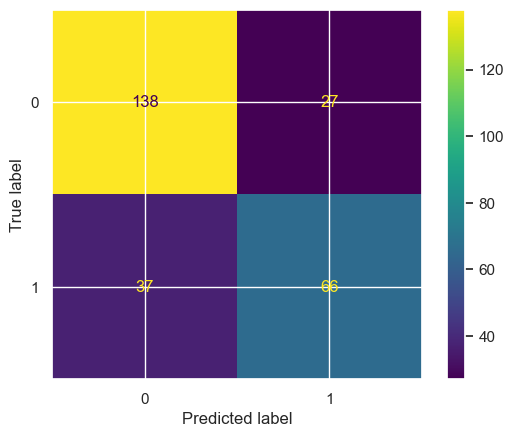

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
mat = confusion_matrix(
    test_predictions['Survived'],
    test_predictions['predicted'],
    labels=knn_grid.classes_
)

mat_display = ConfusionMatrixDisplay(
    confusion_matrix=mat,display_labels=knn_grid.classes_
)
mat_display.plot()

**_Fig_.8 Confusion Matrix between true label and predicted label where 1=Survived and 0=Did not survive**

From the confusion matrix, we can see that our model has more false negatives than false positives. Namely, it tends to predict that a passenger does not survive given that the passenger did survive.

<!-- param_grid = {
    "kneighborsclassifier__n_neighbors":range(1,100,5),
}

tune_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv=10)


accuracies_grid = pd.DataFrame(
    tune_grid
    .fit(X_train,y_train)
    .cv_results_)

#modifies the accuracies_grid to be more readable
accuracies_grid = accuracies_grid[["param_kneighborsclassifier__n_neighbors", "mean_test_score", "std_test_score"]
              ].assign(
                  sem_test_score = accuracies_grid["std_test_score"] / 10**(1/2)
              ).rename(
                  columns = {"param_kneighborsclassifier__n_neighbors" : "n_neighbors"}
              ).drop(
                  columns = ["std_test_score"]
              )

accuracies_grid -->

### 3. Multivariate KNN with All Features

Next, we'll be using multivariate `KNN` with all the features in our dataset and use `GridSearch` to try out different hyperparameter values.

#### Preprocessing

We create a preprocessor performing the transformations to the features we describe above.

In [27]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Embarked']
binary_features = ['Sex']
drop_features = ['PassengerId', 'Cabin', 'Ticket', 'Name']
passthrough_features = ['Pclass']
target = "Survived"

# Check that we accounted for all features
assert set([target] + numeric_features + categorical_features + binary_features + passthrough_features + drop_features) == set(training_data.columns)

# Create ColumnTransformer
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_features),
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore', sparse=False)), categorical_features),
    (OneHotEncoder(drop='if_binary'), binary_features),
    ('passthrough', passthrough_features),
    ('drop', drop_features)
)

display(preprocessor)
transformed = preprocessor.fit_transform(training_data)
column_names = (
    numeric_features
    + preprocessor.named_transformers_['pipeline-2'].get_feature_names_out().tolist()
    + binary_features
    + passthrough_features
)

print(f'Shape of data: {transformed.shape} of type {type(transformed)}')
pd.DataFrame(transformed, columns=column_names)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Embarked']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'), ['Sex']),
                                ('passthrough', 'passthrough', ['Pclass']),
                                ('drop', 'drop',
                                 ['PassengerId', 'Cabin', 'Ticket', 'Name'])])

Shape of data: (623, 10) of type <class 'numpy.ndarray'>


,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S,Sex,Pclass
0,-0.389891,-0.464774,-0.465958,-0.355007,0.0,0.0,0.0,1.0,0.0,2.0
1,0.000000,-0.464774,-0.465958,-0.455499,0.0,0.0,1.0,0.0,1.0,3.0
2,0.000000,-0.464774,-0.465958,-0.455023,0.0,0.0,1.0,0.0,0.0,3.0
3,-1.021107,-0.464774,-0.465958,-0.449307,0.0,0.0,0.0,1.0,1.0,3.0
4,0.000000,-0.464774,-0.465958,-0.455023,0.0,0.0,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
618,0.478031,-0.464774,-0.465958,9.157538,1.0,0.0,0.0,0.0,1.0,1.0
619,0.872542,0.412663,4.582592,-0.071152,0.0,0.0,0.0,1.0,1.0,3.0
620,0.000000,0.412663,-0.465958,0.387969,0.0,0.0,0.0,1.0,0.0,1.0
621,1.188150,1.290100,-0.465958,1.111893,0.0,0.0,1.0,0.0,1.0,1.0


**Analysis**
- Our numerical features have been scaled and missing values of `Age` have been imputed with the mean value
- Our categorical features have been one hot encoded and missing values of `Embarked` have been imputed with the constant `Missing`
- We dropped the irrelevant features mentioned earlier
- We create a numerical binary column for `Sex`

In [28]:
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
knn_grid, _ = tune_knn(knn_pipe, 'multivariate knn')

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Embarked']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Sex']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Pclass']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['PassengerId',
                                                                          'Cabin',
                                                                          'Ticket',
                                                                          'Name'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 100, 5)},
             return_train_score=True, scoring='accuracy')

Best accuracy score: 0.8008704557091653
Best hyper-parameters: {'kneighborsclassifier__n_neighbors': 21}


rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.80087,0.799206,0.794393,0.788044,0.781592,0.780031,0.764055,0.763978,0.760855,0.747926,0.746416,0.739939,0.7383,0.736738,0.735125,0.733513,0.733487,0.730261,0.728674,0.728674
std_test_score,0.048748,0.051043,0.0419,0.054975,0.057693,0.052074,0.044348,0.046453,0.047246,0.048126,0.047509,0.049345,0.048125,0.048419,0.048623,0.052185,0.05236,0.052237,0.048896,0.045018
mean_train_score,0.819688,0.822008,0.822719,0.813091,0.842694,0.79151,0.774566,0.986446,0.779736,0.750313,0.760299,0.747634,0.743356,0.74514,0.753703,0.739432,0.741038,0.737292,0.736042,0.734616
std_train_score,0.008186,0.00722,0.009957,0.006661,0.007746,0.013321,0.009829,0.001816,0.007963,0.007503,0.007923,0.009177,0.005158,0.007996,0.009919,0.005408,0.00515,0.003397,0.004993,0.004988
param_kneighborsclassifier__n_neighbors,21,16,11,26,6,31,41,1,36,61,46,56,71,66,51,81,76,86,91,96


,fit_time,score_time,test_score,train_score
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)
knn (age & fare),0.012 (+/- 0.003),0.012 (+/- 0.004),0.676 (+/- 0.048),0.735 (+/- 0.010)
knn SelectKBest,0.006 (+/- 0.001),0.007 (+/- 0.001),0.799 (+/- 0.061),0.790 (+/- 0.008)
multivariate knn,0.018 (+/- 0.001),0.014 (+/- 0.001),0.801 (+/- 0.051),0.820 (+/- 0.009)


We can see that the value `k=21` achieved the best mean validation score of approximately 0.801.

The next line of code uses the best model from the grid search using `KNN` to add to our `results` object.

Thus, with multivariate KNN with the optimal hyperparameter `n_neighbors=16`, we have achieved a validation score of 0.801 which is a major improvement over our baseline, but a minor improvement compared to using `SelectKBest`. Our model doesn't seem to be overfitting because the train and test score are low.

### 4. Various other models

In the next section, we'll try out various other models without tuning the hyperparameters to see the validation scores we get.

In [29]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "rbf svm": SVC(random_state=123),
    "random forest": RandomForestClassifier(n_jobs=-1, random_state=123),
    "xgboost": XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0, n_jobs=-1),
    "lgbm": LGBMClassifier(random_state=123, verbosity=-1, n_jobs=-1)
}

for model in models.items():

    pipe = make_pipeline(preprocessor, model[1])

    result[model[0]] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=10, return_train_score=True, scoring='accuracy'
    )

pd.DataFrame(result).T.sort_values(by='test_score', ascending=False)

,fit_time,score_time,test_score,train_score
rbf svm,0.035 (+/- 0.003),0.015 (+/- 0.005),0.815 (+/- 0.069),0.834 (+/- 0.008)
random forest,0.947 (+/- 2.366),0.045 (+/- 0.005),0.814 (+/- 0.055),0.986 (+/- 0.002)
lgbm,0.169 (+/- 0.013),0.023 (+/- 0.003),0.807 (+/- 0.045),0.950 (+/- 0.007)
multivariate knn,0.018 (+/- 0.001),0.014 (+/- 0.001),0.801 (+/- 0.051),0.820 (+/- 0.009)
knn SelectKBest,0.006 (+/- 0.001),0.007 (+/- 0.001),0.799 (+/- 0.061),0.790 (+/- 0.008)
xgboost,0.135 (+/- 0.007),0.025 (+/- 0.001),0.790 (+/- 0.051),0.976 (+/- 0.003)
decision tree,0.022 (+/- 0.010),0.018 (+/- 0.022),0.763 (+/- 0.052),0.986 (+/- 0.002)
knn (age & fare),0.012 (+/- 0.003),0.012 (+/- 0.004),0.676 (+/- 0.048),0.735 (+/- 0.010)
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)


Thus, the best performing model is `rbf svm` which achieves a validation score of about 0.815!

### Evaluation on Test Set

Lastly, we'll use our best KNN model, train it on the entire training set and evaluate it on the test set.

In [30]:
best_knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['kneighborsclassifier__n_neighbors'])
best_pipe = make_pipeline(preprocessor, best_knn)
best_pipe.fit(X_train, y_train)
best_pipe.score(X_test, y_test)

0.8059701492537313

Thus, we have achieved a test score of approximately 0.806.

# Discussion



In [31]:
pd.DataFrame(result).T.sort_values(by='test_score', ascending=False)

,fit_time,score_time,test_score,train_score
rbf svm,0.035 (+/- 0.003),0.015 (+/- 0.005),0.815 (+/- 0.069),0.834 (+/- 0.008)
random forest,0.947 (+/- 2.366),0.045 (+/- 0.005),0.814 (+/- 0.055),0.986 (+/- 0.002)
lgbm,0.169 (+/- 0.013),0.023 (+/- 0.003),0.807 (+/- 0.045),0.950 (+/- 0.007)
multivariate knn,0.018 (+/- 0.001),0.014 (+/- 0.001),0.801 (+/- 0.051),0.820 (+/- 0.009)
knn SelectKBest,0.006 (+/- 0.001),0.007 (+/- 0.001),0.799 (+/- 0.061),0.790 (+/- 0.008)
xgboost,0.135 (+/- 0.007),0.025 (+/- 0.001),0.790 (+/- 0.051),0.976 (+/- 0.003)
decision tree,0.022 (+/- 0.010),0.018 (+/- 0.022),0.763 (+/- 0.052),0.986 (+/- 0.002)
knn (age & fare),0.012 (+/- 0.003),0.012 (+/- 0.004),0.676 (+/- 0.048),0.735 (+/- 0.010)
baseline,0.002 (+/- 0.000),0.001 (+/- 0.000),0.616 (+/- 0.005),0.616 (+/- 0.001)


To summarize, we tried several different models of KNN. One with two features chosen through our EDA, another with `SelectKBest` and one using all features. We also tried several other models like ensemble methods and `RBF SVM`. Amongst the three KNN models, the multivariate `KNN` had the best cross validation accuracy of about 0.801 and achieved a test score of about 0.806.

However, `rbf svm` as seen above has the best validation score of 0.815 and in the future, we would tune the hyperparameters for `rbf svm` to see if it's possible to get an even higher score.

## Whether this was expected

Based on our EDA, we saw that a lot of points were quite cluttered and so we didn't expect `KNN` to be able to do that well since the decision boundaries it would need to come up with to separate the data would be very complex and could overfit to the training set.

## Impact of Findings and Future Questions

Through data analysis with classification, we want to figure out what sort of people were more likely to survive from Titanic shipwrecks. As we classify the training data set, we could find specific variables/features such as “sex” or “ticket class” that influence the likelihood of survival in the Titanic disaster. For example, we would expect that passengers with higher ticket classes or those who lived in higher cabin numbers might have survived more than other groups of people. The impact of these findings can help us better understand which groups of people were more likely to survive than others. This could lead to future questions such as whether these groups shared similarities to survivors of other large-scale boat accidents or natural disasters that also resulted in a large number of deaths. Lastly, we could use these findings and further research methodologies to maximize the number of survivors in case an event like this were to happen again.

# Sources

1. https://www.kaggle.com/competitions/titanic/overview
2. https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook
3. https://www.encyclopedia-titanica.org/cabins.html
4. https://titanicfacts.net/titanic-ship/

